# Message-passing Neural Networks (MPNN) for predicting molecular properties

## Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

from dgl.data.utils import split_dataset
from dgl.dataloading import GraphDataLoader

from param_ml.models.mpnn import VanillaMPNN
from param_ml.utils.datasets import MolDataset
from param_ml.utils.featurizers import ElementAtomFeaturizer
from param_ml.utils.training import eval_one_epoch, train_one_epoch

ALLOWABLE_SET = ["C", "N", "O", "S", "F", "P", "Cl", "Br", "I", "H"]

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
run_on_gpu = True if device == 'cuda:0' else False
print(f'Running on {device}')

Running on cuda:0


## Dataset

### Statistics

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:568: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


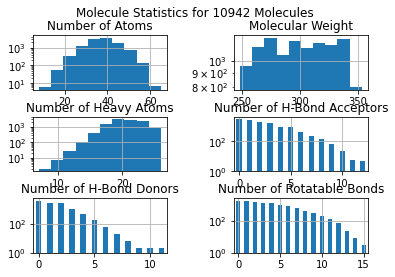

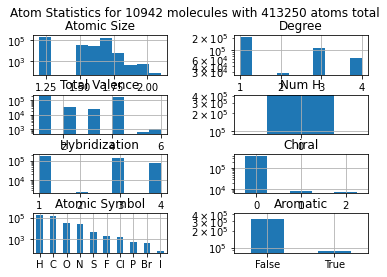

In [14]:
from param_ml.metrics.eda_mol_file import get_mols_from_mol2_file, MolStats, MolStatsPlotter

mols = get_mols_from_mol2_file(mol2_file='data/raw/riniker_subset.mol2')
mol_stats = [MolStats(mol) for mol in mols]
mol_stats_plotter = MolStatsPlotter(mol_stats)

mol_stats_plotter.show_plots()

### Data loader

In [15]:
atom_featurizer = ElementAtomFeaturizer(
    allowable_set=ALLOWABLE_SET,
    encode_unknown=False
)

mol_dataset = MolDataset(
    name='riniker_subset',
    mol_file='data/raw/riniker_subset.mol2',
    raw_dir='data/raw',
    save_dir='data/processed',
    atom_featurizer=atom_featurizer,
    mol_selection = list(range(len(mols))),
    in_memory=False,
    num_processes = 1,
    sanitize=True,
    remove_hs=False,
    bond_featurizer=None,
    force_reload=True,
    simple_read=False,
    verbose=False
)

--- Processing molecules with 1 processes ---
--- Building molecule index ---
--- Reading molecule blocks ---
--- Subsetting molecule list ---
--- Removing invalid molecules ---
--- Creating graphs ---
Graphs and featurization done in 19.8


In [16]:
train, valid = split_dataset(
    mol_dataset,
    frac_list=[0.9, 0.1],
    shuffle=True,
    random_state=42
)

batch_size = 32

train_dataloader = GraphDataLoader(
    valid,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False)

valid_dataloader = GraphDataLoader(
    valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False)

print(f'Train size: {len(train)}')
print(f'Valid size: {len(valid)}')

Train size: 9847
Valid size: 1095


## Model

In [17]:
model = VanillaMPNN(
    node_in_feats=mol_dataset[0][0].ndata['feats'].shape[1],
    edge_in_feats=mol_dataset[0][0].edata['e'].shape[1],
    node_hidden_feats=[64, 128],
    edge_hidden_feats=[32, 64, 128],
    ntasks=1,
    do_batchnorm=True,
    readout_type='node',
    bias=True
).to(device)

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training

In [18]:
train_times = []
train_losses = []
valid_times = []
valid_losses = []

n_epochs = 3
for epoch in range(n_epochs):
    loss_epoch, time_epoch, train_labels = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device)
    train_losses.append(loss_epoch)
    train_times.append(time_epoch)

    valid_loss, valid_time, valid_labels = eval_one_epoch(valid_dataloader, model, loss_fn, device)
    valid_losses.append(valid_loss)
    valid_times.append(valid_time)

    print(f'Epoch {epoch+1:d}/{n_epochs:d}:') 
    print(f"Epoch training time: {time_epoch:.5} seconds")
    print(f'Epoch average loss: {loss_epoch:.4f}')
    print(f"Validation time: {valid_time:.5} seconds")
    print(f'Validation average loss: {valid_loss:.4f}')


Epoch 1/3:
Epoch training time: 7.4011 seconds
Epoch average loss: 0.0497
Validation time: 2.8543 seconds
Validation average loss: 0.0400
Epoch 2/3:
Epoch training time: 7.2692 seconds
Epoch average loss: 0.0194
Validation time: 3.0534 seconds
Validation average loss: 0.0174
Epoch 3/3:
Epoch training time: 8.2407 seconds
Epoch average loss: 0.0169
Validation time: 3.291 seconds
Validation average loss: 0.0162


## Evaluation

In [19]:
from param_ml.metrics.evaluate_model import evaluate_model, make_node_mapping, make_df_from_node_mapping

true_labels, pred_labels = evaluate_model(model, valid_dataloader, device)

node_map = make_node_mapping(valid, true_labels, pred_labels)
df = make_df_from_node_mapping(node_map)


<AxesSubplot:title={'center':'RMSE by Element'}, xlabel='Element', ylabel='RMSE'>

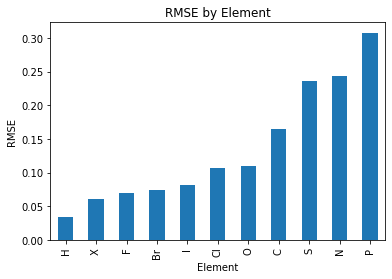

In [20]:
df['squared_error'] = (df['pred'] - df['true'])**2
(df
 .groupby('element')['squared_error']
 .mean()
 .apply(np.sqrt)
 .sort_values()
 .plot(
     kind='bar',
     xlabel='Element',
     ylabel='RMSE',
     title='RMSE by Element'
    )
)

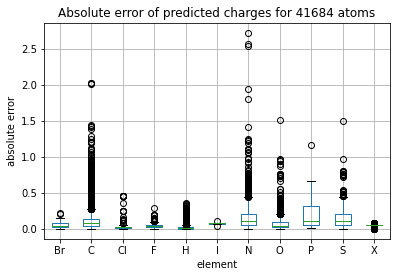

In [21]:
df.boxplot(column='abs_error', by='element')
num_atoms = len(df)
plt.title(f"Absolute error of predicted charges for {num_atoms} atoms")
plt.suptitle("")
plt.ylabel("absolute error")
plt.show()

Text(0.5, 1.0, 'Cumulative absolute error by element')

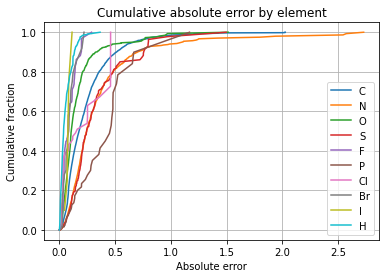

In [22]:
fig, ax = plt.subplots()
for element in ALLOWABLE_SET:
    df_element = df[df['element'] == element]
    df_element = df_element.sort_values(by=['abs_error'])
    df_element['cumsum'] = df_element['abs_error'].cumsum()
    df_element['cumsum'] = df_element['cumsum'] / df_element['cumsum'].max()
    ax.plot(df_element['abs_error'], df_element['cumsum'], label=element)
ax.set_xlabel('Absolute error')
ax.set_ylabel('Cumulative fraction')
ax.legend()
ax.grid(True)
plt.title('Cumulative absolute error by element')